<a href="https://colab.research.google.com/github/nattntn/PMU-B-PersonalAI/blob/main/Test_Hack_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [1]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import

In [2]:
import os
import numpy as np
import pandas as pd
#import efficientnet.tfkeras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

In [77]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import datetime

In [78]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Clone Efficient

In [3]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


# Load Model

In [84]:
import sys
sys.path.append('/content/gdrive/MyDrive/Hackathon/Model/Freeze_R3.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})


In [85]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Hackathon/Model/Freeze_R3.h5")
model.summary()

Model: "EffNet_skin"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normalizatio

In [86]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

height: 224, width: 224


# Data Preparation

In [7]:
train = pd.read_csv(r'/content/gdrive/MyDrive/Hackathon/Table_train.csv')
train

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,1141,HAM_0003290,ISIC_0031735,df,histo,80.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,12,HAM_0004234,ISIC_0025984,bkl,histo,85.0,female,chest,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,2414,HAM_0004097,ISIC_0025677,vasc,consensus,50.0,female,abdomen,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,36,HAM_0000351,ISIC_0029559,bkl,histo,85.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,3066,HAM_0005858,ISIC_0028879,nv,follow_up,55.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...,...
639,9776,HAM_0005389,ISIC_0024372,akiec,histo,70.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
640,2429,HAM_0006193,ISIC_0029877,vasc,consensus,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
641,2471,HAM_0002134,ISIC_0024431,bcc,histo,45.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
642,2980,HAM_0001940,ISIC_0028502,nv,follow_up,45.0,female,abdomen,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [8]:
train = train.iloc[:,1:]

In [9]:
DATA_PATH = "/content/gdrive/MyDrive/Hackathon/Skin Cancer/Skin Cancer"
os.chdir(DATA_PATH)
# train_dir = os.path.join(DATA_PATH, 'Normal')
# print(train_dir)
# test_dir = os.path.join(DATA_PATH, 'Test')
# print(test_dir)

In [10]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'dx',
        class_mode = 'categorical',
        color_mode= 'rgb',
        target_size=(height, width),# รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        batch_size=batch_size)
#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 644 validated image filenames belonging to 7 classes.
{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [11]:
test = pd.read_csv (r'/content/gdrive/MyDrive/Hackathon/Table_test.csv')
test

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,2348,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,1258,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,2547,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,2495,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,1300,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...,...
75,2523,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,1199,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,109,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,1131,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [12]:
test = test.iloc[:,1:]
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


# Predict

In [13]:
model.output_names

['Prediction_Dis']

In [14]:
act = test['dx'].tolist() #ค่าจริง
path = test['Path_Name'].tolist() #path

In [15]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [16]:
predict_image(path[0])

1/1 [==============================] - 5s 5s/step


array([2.5739725e-08, 3.8819035e-08, 4.7045909e-08, 5.6297745e-07,
       2.0283189e-06, 1.8319923e-07, 9.9999702e-01], dtype=float32)

In [17]:
#Predict
pred_list = list()
prob_list = list()
pred_Re = list()

for i in range(0,len(path)):
    predict = predict_image(path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    pred_Re.append(result)
    prob_list.append(predict[result])

1/1 [==============================] - 0s 25ms/step


In [18]:
pred_list

['vasc',
 'mel',
 'bcc',
 'df',
 'bkl',
 'df',
 'df',
 'bkl',
 'nv',
 'nv',
 'vasc',
 'bcc',
 'bkl',
 'mel',
 'df',
 'akiec',
 'mel',
 'vasc',
 'bcc',
 'bcc',
 'mel',
 'bkl',
 'bcc',
 'nv',
 'bkl',
 'mel',
 'nv',
 'nv',
 'vasc',
 'vasc',
 'mel',
 'bcc',
 'mel',
 'bcc',
 'akiec',
 'df',
 'df',
 'vasc',
 'vasc',
 'bcc',
 'mel',
 'nv',
 'bkl',
 'mel',
 'mel',
 'bcc',
 'mel',
 'akiec',
 'df',
 'vasc',
 'bcc',
 'akiec',
 'bkl',
 'df',
 'bkl',
 'nv',
 'mel',
 'nv',
 'akiec',
 'mel',
 'bcc',
 'nv',
 'df',
 'nv',
 'vasc',
 'bcc',
 'mel',
 'nv',
 'df',
 'mel',
 'nv',
 'bkl',
 'nv',
 'vasc',
 'bkl',
 'bcc',
 'df',
 'bkl',
 'df',
 'bcc']

In [19]:
prob_list

[0.999997,
 0.9932307,
 0.94981515,
 0.89606756,
 0.6050272,
 0.99396014,
 0.89090514,
 0.5877036,
 0.83833045,
 0.9717197,
 0.9882858,
 0.79478055,
 0.52769655,
 0.89163226,
 0.9570038,
 0.73232275,
 0.99912673,
 1.0,
 0.9973151,
 0.99972254,
 0.917867,
 0.9999844,
 0.5429306,
 0.99915504,
 0.9437867,
 0.9512974,
 0.99681467,
 0.99986374,
 0.5059968,
 0.99999666,
 0.99623847,
 0.9999924,
 0.8973887,
 0.9907646,
 0.98582214,
 0.9949018,
 0.99982905,
 0.9999987,
 1.0,
 0.56103116,
 1.0,
 0.99998796,
 0.93819416,
 0.9999994,
 0.5098807,
 0.9514808,
 0.99975866,
 0.8375677,
 0.8104186,
 0.9999745,
 0.71736807,
 0.9952602,
 0.93285644,
 0.9980184,
 0.9979175,
 0.9970542,
 0.74429184,
 0.9989951,
 0.88000935,
 0.9992187,
 0.9551332,
 0.6316331,
 0.9246012,
 1.0,
 0.999967,
 0.9999813,
 0.9999722,
 0.9977162,
 0.99518245,
 0.9004914,
 0.9999844,
 0.9999863,
 0.99990606,
 0.9999894,
 0.99811184,
 0.98196995,
 0.9985669,
 0.7083151,
 0.8986095,
 0.9999974]

# Prediction

In [20]:
prob_list

[0.999997,
 0.9932307,
 0.94981515,
 0.89606756,
 0.6050272,
 0.99396014,
 0.89090514,
 0.5877036,
 0.83833045,
 0.9717197,
 0.9882858,
 0.79478055,
 0.52769655,
 0.89163226,
 0.9570038,
 0.73232275,
 0.99912673,
 1.0,
 0.9973151,
 0.99972254,
 0.917867,
 0.9999844,
 0.5429306,
 0.99915504,
 0.9437867,
 0.9512974,
 0.99681467,
 0.99986374,
 0.5059968,
 0.99999666,
 0.99623847,
 0.9999924,
 0.8973887,
 0.9907646,
 0.98582214,
 0.9949018,
 0.99982905,
 0.9999987,
 1.0,
 0.56103116,
 1.0,
 0.99998796,
 0.93819416,
 0.9999994,
 0.5098807,
 0.9514808,
 0.99975866,
 0.8375677,
 0.8104186,
 0.9999745,
 0.71736807,
 0.9952602,
 0.93285644,
 0.9980184,
 0.9979175,
 0.9970542,
 0.74429184,
 0.9989951,
 0.88000935,
 0.9992187,
 0.9551332,
 0.6316331,
 0.9246012,
 1.0,
 0.999967,
 0.9999813,
 0.9999722,
 0.9977162,
 0.99518245,
 0.9004914,
 0.9999844,
 0.9999863,
 0.99990606,
 0.9999894,
 0.99811184,
 0.98196995,
 0.9985669,
 0.7083151,
 0.8986095,
 0.9999974]

In [21]:
pred_arr = np.array(pred_list) #แปลงเป็น array
act_arr = np.array(act)

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_arr, pred_arr)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_arr, pred_arr))#performance

classifier accuracy = 78.75%
              precision    recall  f1-score   support

       akiec       1.00      0.42      0.59        12
         bcc       0.71      0.83      0.77        12
         bkl       0.73      0.73      0.73        11
          df       0.75      0.82      0.78        11
         mel       0.60      0.82      0.69        11
          nv       0.92      1.00      0.96        12
        vasc       1.00      0.91      0.95        11

    accuracy                           0.79        80
   macro avg       0.82      0.79      0.78        80
weighted avg       0.82      0.79      0.78        80



Text(0.5, 76.24999999999999, 'Predicted label')

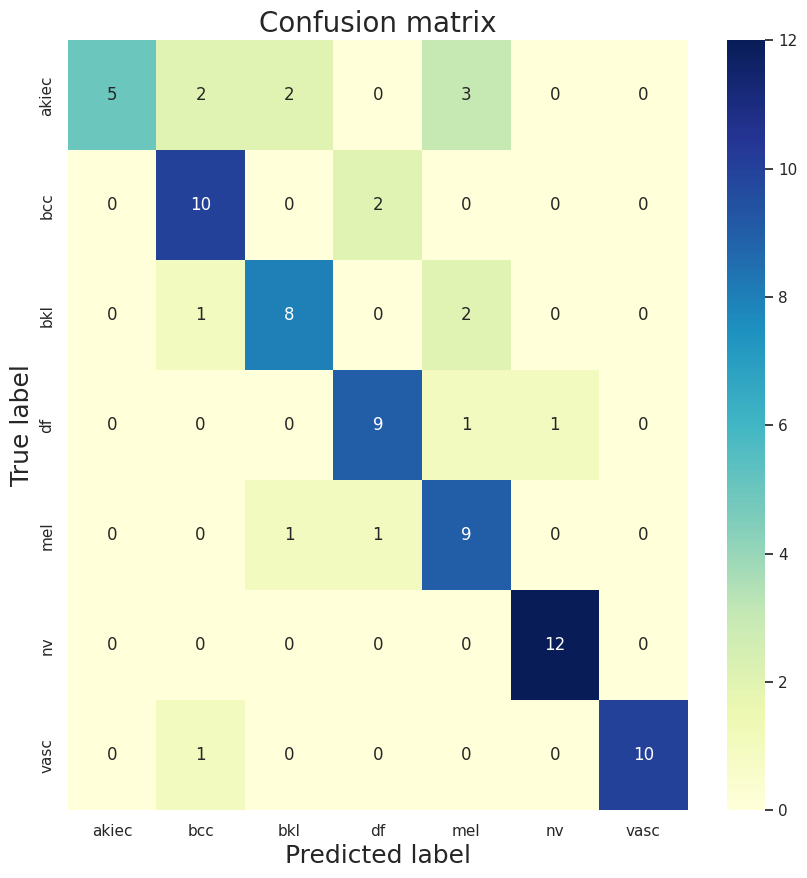

In [23]:
#create CF
data = {'Actual': act_arr,'Predicted' : pred_arr,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_arr, pred_arr)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

# ตารางรวม

In [24]:
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [25]:
#Regression
test['Predict'] = pred_list # ผลที่ทำนาย
test['Prob'] = prob_list

In [26]:
test['Pre_int'] = pred_Re

In [27]:
labels

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [28]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace df with the actual name of your DataFrame if different

# Create a dictionary to map disease names to category names
disease_to_category = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6,
    # Add more mappings as needed
}

# Map the values in the "Disease" column to the corresponding categories
test['label_dx'] = test['dx'].map(disease_to_category)

# Display the updated DataFrame
print(test)


      lesion_id      image_id    dx    dx_type   age     sex     localization  \
0   HAM_0003771  ISIC_0026163  vasc      histo  50.0  female             hand   
1   HAM_0004720  ISIC_0028642   mel      histo  40.0    male  lower extremity   
2   HAM_0002717  ISIC_0031284   bcc      histo  75.0    male             face   
3   HAM_0004871  ISIC_0030261   bcc      histo  70.0    male             back   
4   HAM_0006521  ISIC_0025155   mel      histo  80.0    male  lower extremity   
..          ...           ...   ...        ...   ...     ...              ...   
75  HAM_0005309  ISIC_0026282   bcc      histo  50.0    male  upper extremity   
76  HAM_0002848  ISIC_0027598    df  consensus  60.0  female  lower extremity   
77  HAM_0001417  ISIC_0032382   bkl      histo  55.0    male             face   
78  HAM_0002706  ISIC_0025954    df      histo  40.0    male  lower extremity   
79  HAM_0000195  ISIC_0028495   bcc      histo  50.0  female             back   

                           

In [29]:
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name,Predict,Prob,Pre_int,label_dx
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,vasc,0.999997,6,6
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,mel,0.993231,4,4
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bcc,0.949815,1,1
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.896068,3,1
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bkl,0.605027,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bcc,0.981970,1,1
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.998567,3,3
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bkl,0.708315,2,2
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.898610,3,3


# ROC

In [56]:
prob_list

[0.999997,
 0.9932307,
 0.94981515,
 0.89606756,
 0.6050272,
 0.99396014,
 0.89090514,
 0.5877036,
 0.83833045,
 0.9717197,
 0.9882858,
 0.79478055,
 0.52769655,
 0.89163226,
 0.9570038,
 0.73232275,
 0.99912673,
 1.0,
 0.9973151,
 0.99972254,
 0.917867,
 0.9999844,
 0.5429306,
 0.99915504,
 0.9437867,
 0.9512974,
 0.99681467,
 0.99986374,
 0.5059968,
 0.99999666,
 0.99623847,
 0.9999924,
 0.8973887,
 0.9907646,
 0.98582214,
 0.9949018,
 0.99982905,
 0.9999987,
 1.0,
 0.56103116,
 1.0,
 0.99998796,
 0.93819416,
 0.9999994,
 0.5098807,
 0.9514808,
 0.99975866,
 0.8375677,
 0.8104186,
 0.9999745,
 0.71736807,
 0.9952602,
 0.93285644,
 0.9980184,
 0.9979175,
 0.9970542,
 0.74429184,
 0.9989951,
 0.88000935,
 0.9992187,
 0.9551332,
 0.6316331,
 0.9246012,
 1.0,
 0.999967,
 0.9999813,
 0.9999722,
 0.9977162,
 0.99518245,
 0.9004914,
 0.9999844,
 0.9999863,
 0.99990606,
 0.9999894,
 0.99811184,
 0.98196995,
 0.9985669,
 0.7083151,
 0.8986095,
 0.9999974]

In [ ]:
# pred_arr = np.array(pred_list) #แปลงเป็น array
# act_arr = np.array(act)

In [64]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'act_arr' is your array of class labels
label_encoder = LabelEncoder()
act_arr_encoded = label_encoder.fit_transform(act_arr)
# pred_arr_encoded = label_encoder.fit_transform(pred_arr)

# Now 'act_arr_encoded' contains numerical labels


In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):  # Assuming num_classes is 7
    fpr[i], tpr[i], _ = roc_curve((act_arr_encoded == i).astype(int), prob_list)
    roc_auc[i] = auc(fpr[i], tpr[i])


In [71]:
label = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

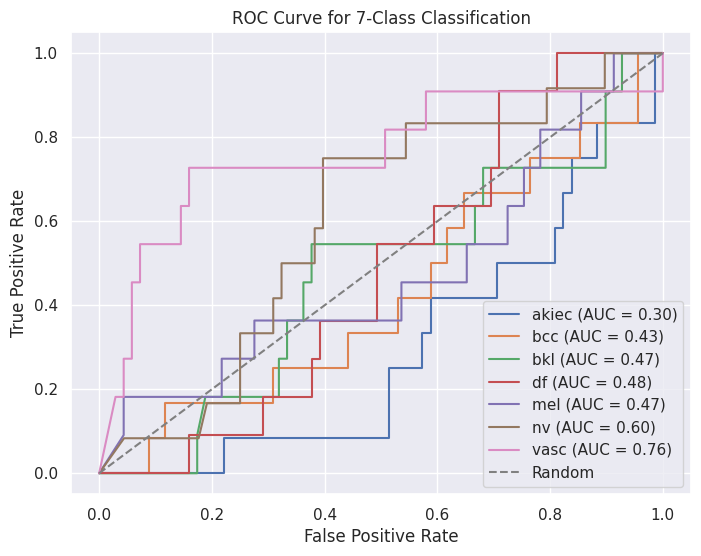

In [72]:
plt.figure(figsize=(8, 6))

for i in range(7):
    class_i = labels[i]
    #plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot(fpr[i], tpr[i], label=f'{class_i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 7-Class Classification')
plt.legend()
plt.show()


# Grad-CAM

In [75]:
!pip install tensorflow tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 389.3 kB/s eta 0:00:00


In [89]:
model.summary()

Model: "EffNet_skin"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normalizatio

In [92]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.applications import EfficientNetB0
from tf_explain.core.grad_cam import GradCAM

# Load the pre-trained EfficientNetB0 model
# model = EfficientNetB0(weights='imagenet')

# Load an image for visualization
img_path = '/content/gdrive/MyDrive/Hackathon/Skin Cancer/Skin Cancer/ISIC_0034304.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Create a model that outputs the layer of interest (e.g., the last convolutional layer)
# In EfficientNetB0, you can use the block7a_project_conv layer as an example
last_conv_layer = model.get_layer('swish_48')

# Create a model that includes the input image and the last convolutional layer
grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

# Get the predicted class index
pred_index = np.argmax(model.predict(img_array))

# Generate class activation heatmap
explainer = GradCAM()
heatmap = explainer.explain(img_array, grad_model, class_index=pred_index, layer_name=last_conv_layer.name)

# Resize the heatmap to the original image size
heatmap = tf.image.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = tf.image.grayscale_to_rgb(heatmap)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img_array[0]

# Save or display the result
result_path = '/content/gdrive/MyDrive/Hackathon/test_grad.jpg'
image.save_img(result_path, superimposed_img)

1/1 [==============================] - 0s 61ms/step


ValueError: not enough values to unpack (expected 2, got 1)

In [93]:
# Load an image for visualization
img_path = '/content/gdrive/MyDrive/Hackathon/Skin Cancer/Skin Cancer/ISIC_0034304.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Create a model that outputs the layer of interest (e.g., the last convolutional layer)
# In EfficientNetB0, you can use the block7a_project_conv layer as an example
last_conv_layer = model.get_layer('swish_48')

# Create a model that includes the input image and the last convolutional layer
grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

# Get the predicted class index
pred_index = np.argmax(model.predict(img_array))

# Generate class activation heatmap
explainer = GradCAM()
heatmap = explainer.explain((img_array, None), grad_model, class_index=pred_index, layer_name=last_conv_layer.name)

# Resize the heatmap to the original image size
heatmap = tf.image.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = tf.image.grayscale_to_rgb(heatmap)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img_array[0]

# Save or display the result
result_path = '/content/gdrive/MyDrive/Hackathon/test_grad.jpg'
image.save_img(result_path, superimposed_img)

1/1 [==============================] - 0s 60ms/step


TypeError: list indices must be integers or slices, not tuple